# Initialize directories

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

input_dir = "/kaggle/input"
output_dir = "/kaggle/working"

# Flickr8k dataset path
dataset_path = os.path.join(input_dir, "flickr8k")
image_dir = os.path.join(dataset_path, 'Images')
captions_file = os.path.join(dataset_path, 'captions.txt')

# Saved CLIP Model directory
model_dir = os.path.join(input_dir, "custom-clip-model-flickr8k")
fine_tuned_clip_path = os.path.join(model_dir, "fine_tuned_clip")
fine_tuned_clip_processor_path = os.path.join(model_dir, "fine_tuned_clip_processor")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Install requirements

In [3]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 28.3 MB/s eta 0:00:00a 0:00:01


# Import libraries

In [5]:
import os
import torch
import logging
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, CLIPTextModel, CLIPTokenizer

# For testing CLIP model
from diffusers import StableDiffusionPipeline

# For generating images
import shutil
import math
from tqdm import tqdm
from IPython.display import display
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

# disable warnings
logging.disable(logging.WARNING)

# Constant variable declaration

In [6]:
height = 224
width = 224
batch_size = 8
shuffle = True
num_epochs = 5

# Check device type (cuda/cpu)

In [7]:
# Initialize CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
# Load pre-trained LDM (Stable Diffusion)
pipeline = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
pipeline.to(device)

# Load fine-tuned CLIP
clip_model = CLIPTextModel.from_pretrained(fine_tuned_clip_path)
clip_processor = CLIPTokenizer.from_pretrained(fine_tuned_clip_processor_path)

def generate_image(text_prompt):
    # Encode text using fine-tuned CLIP
    inputs = clip_processor(text=text_prompt, return_tensors="pt", padding=True)
    with torch.no_grad():
        text_embeddings = clip_model(**inputs).last_hidden_state

    # Generate image using LDM
    # generated_image = pipeline(prompt_embeds=text_embeddings, guidance_scale=7.5, height=height, width=width)
    generated_image = pipeline(prompt_embeds=text_embeddings, guidance_scale=7.5)
    image = generated_image.images[0]

    plt.imshow(image)
    plt.title(text_prompt if text_prompt else "<No Text>")
    plt.axis("off")
    plt.show()

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

# Create classes

## Custom Flickr8k Dataset class

In [7]:
class Flickr8kDataset(Dataset):
    def __init__(self, images_dir, captions_df, transform=None):
        self.images_dir = images_dir
        self.captions_df = captions_df
        self.transform = transform

    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, idx):
        image_name = self.captions_df.iloc[idx, 0]
        caption = self.captions_df.iloc[idx, 1]

        # Load image
        image_path = os.path.join(self.images_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return {"image": image, "caption": caption}

# Define transforms for images
transform = transforms.Compose([
    transforms.Resize((height, width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

# Load captions
captions_df = pd.read_csv(captions_file)

# Create dataset and DataLoader
dataset = Flickr8kDataset(images_dir=image_dir, captions_df=captions_df, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

## Fine tune CLIP model on Flickr8k

In [8]:
class Fine_tune_clip:
    """
    A class for fine-tuning a CLIP model with a custom dataset.

    Attributes:
        dataloader (torch.utils.data.DataLoader): The dataloader for loading training data.
        clip_model (transformers.CLIPModel): The CLIP model to fine-tune.
        clip_processor (transformers.CLIPProcessor): The processor for preprocessing images and text.
        output_dir (str): The directory where the fine-tuned model and processor will be saved.
        height (int): The height of the input images (default is 224).
        width (int): The width of the input images (default is 224).
        batch_size (int): The batch size for training (default is 8).
        shuffle (bool): Whether to shuffle the dataset (default is True).
        num_epochs (int): The number of epochs for training (default is 5).
        device (str): The device to use for training, e.g., "cuda" or "cpu" (default is "cuda").
        optimizer (torch.optim.Optimizer): The optimizer for training (default is None).
    """
    
    def __init__(self, dataloader, clip_model, clip_processor, output_dir, height=224, width=224, batch_size=8, shuffle=True, num_epochs=5, device="cuda"):
        """
        Initializes the Fine_tune_clip class with the specified dataloader, model, processor, and training parameters.

        Args:
            dataloader (torch.utils.data.DataLoader): The dataloader for loading training data.
            clip_model (transformers.CLIPModel): The CLIP model to fine-tune.
            clip_processor (transformers.CLIPProcessor): The processor for preprocessing images and text.
            output_dir (str): The directory where the fine-tuned model and processor will be saved.
            height (int): The height of the input images (default is 224).
            width (int): The width of the input images (default is 224).
            batch_size (int): The batch size for training (default is 8).
            shuffle (bool): Whether to shuffle the dataset (default is True).
            num_epochs (int): The number of epochs for training (default is 5).
            device (str): The device to use for training, e.g., "cuda" or "cpu" (default is "cuda").
        """
        
        self.dataloader = dataloader
        self.len_dataloader = len(dataloader)
        self.height = height
        self.width = width
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_epochs = num_epochs
        self.clip_model = clip_model
        self.clip_processor = clip_processor
        self.optimizer = None
        self.device = device
        self.output_dir = output_dir

    def set_optimizer(self, lr=1e-5):
        """
        Sets the optimizer for training.

        Args:
            lr (float): The learning rate for the optimizer (default is 1e-5).
        """
        
        self.optimizer = torch.optim.AdamW(self.clip_model.parameters(), lr=lr)

    def train_clip_model(self, num_epochs=5):
        """
        Trains the CLIP model using the specified number of epochs.

        Args:
            num_epochs (int): The number of epochs for training (default is 5).
        """
        
        self.clip_model.train()
        for epoch in range(num_epochs):
            progress_bar = tqdm(self.dataloader, total=self.len_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")
            for idx, batch in enumerate(progress_bar):
                images = batch["image"].to(self.device)
                captions = batch["caption"]
                
                text_inputs = self.clip_processor(text=captions, return_tensors="pt", padding=True).to(self.device)
                
                outputs = self.clip_model(
                    pixel_values=images,
                    input_ids=text_inputs.input_ids,
                    attention_mask=text_inputs.attention_mask,
                    return_loss=True
                )
                loss = outputs.loss
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                progress_bar.set_postfix(loss=loss.item())
        
            # Save the fine-tuned model
            self.clip_model.save_pretrained(os.path.join(self.output_dir, "fine_tuned_clip"))
            self.clip_processor.save_pretrained(os.path.join(self.output_dir, "fine_tuned_clip_processor"))

## Diffusion model (VAE, UNet, Custom CLIP model)

In [11]:
class Diffusion_model:
    """
    A class for generating images using a diffusion model with a VAE and U-Net.

    Attributes:
        vae (AutoencoderKL): The Variational Autoencoder (VAE) for encoding and decoding images.
        unet (UNet2DConditionModel): The U-Net model for noise prediction.
        text_encoder (CLIPTextModel): The text encoder for embedding textual prompts.
        tokenizer (CLIPTokenizer): The tokenizer for processing textual prompts.
        scheduler (LMSDiscreteScheduler): The scheduler for controlling the diffusion steps.
        height (int): The height of the input/output images (default is 224).
        width (int): The width of the input/output images (default is 224).
        device (str): The device for computation, e.g., "cuda" or "cpu" (default is "cuda").
    """
    
    def __init__(self, vae, unet, text_encoder, tokenizer, scheduler, height=224, width=224, device="cuda"):
        """
        Initializes the Diffusion_model class with the specified models, tokenizer, scheduler, and parameters.

        Args:
            vae (AutoencoderKL): The Variational Autoencoder.
            unet (UNet2DConditionModel): The U-Net model for denoising.
            text_encoder (CLIPTextModel): The text encoder for prompt embeddings.
            tokenizer (CLIPTokenizer): The tokenizer for text prompts.
            scheduler (LMSDiscreteScheduler): The scheduler for diffusion steps.
            height (int): The height of the input/output images (default is 224).
            width (int): The width of the input/output images (default is 224).
            device (str): The device for computation, e.g., "cuda" or "cpu" (default is "cuda").
        """
        
        self.vae = vae
        self.unet = unet
        self.text_encoder = text_encoder
        self.tokenizer = tokenizer
        self.scheduler = scheduler
        self.height = height
        self.width = width,
        self.device = device
    
    def load_image(self, img_path):
        """
        Loads and resizes an image from the specified file path.

        Args:
            img_path (str): The file path to the image.

        Returns:
            PIL.Image.Image: The resized image in RGB format.
        """
        
        return Image.open(img_path).convert('RGB').resize((self.height, self.width))
    
    def pil_to_latents(self, image):
        """
        Converts a PIL image to latent space representation.

        Args:
            image (PIL.Image.Image): The input image.

        Returns:
            torch.Tensor: The latent representation of the image.
        """
        
        init_image = transforms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
        init_image = init_image.to(device=self.device, dtype=torch.float16) 
        init_latent_dist = self.vae.encode(init_image).latent_dist.sample() * 0.18215
        return init_latent_dist
    
    def latents_to_pil(self, latents):
        """
        Converts latents back to a PIL image.

        Args:
            latents (torch.Tensor): The latent representation.

        Returns:
            List[PIL.Image.Image]: The decoded images.
        """
        
        latents = (1 / 0.18215) * latents
        with torch.no_grad():
            image = self.vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (image * 255).round().astype("uint8")
        pil_images = [Image.fromarray(image) for image in images]
        return pil_images
    
    def encode_text(self, prompts, maxlen=None):
        """
        Encodes textual prompts into embeddings.

        Args:
            prompts (List[str]): The list of textual prompts.
            maxlen (int): The maximum length for padding (default is tokenizer model's max length).

        Returns:
            torch.Tensor: The embeddings of the prompts.
        """
        
        if maxlen is None:
            maxlen = tokenizer.model_max_length
        inp = self.tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
        return self.text_encoder(inp.input_ids.to(device))[0].half()

    def generate_image(self, prompts, g=7.5, seed=100, steps=70, dim=512, save_int=True):
        """
        Generates an image based on textual prompts using diffusion.

        Args:
            prompts (List[str]): The list of textual prompts.
            g (float): The guidance scale for conditional generation (default is 7.5).
            seed (int): The random seed for reproducibility (default is 100).
            steps (int): The number of diffusion steps (default is 70).
            dim (int): The spatial dimensions of the latent space (default is 512).
            save_int (bool): Whether to save intermediate results (default is True).

        Returns:
            List[PIL.Image.Image]: The generated images.
        """
        
        prompts_batch_size = len(prompts)
        
        encoded_text = self.encode_text(prompts)
        
        uncond_embed =  self.encode_text([""] * prompts_batch_size, encoded_text.shape[1])
        embed = torch.cat([uncond_embed, encoded_text])
        
        if seed:
            torch.manual_seed(seed)
        
        latents = torch.randn((prompts_batch_size, self.unet.config.in_channels, dim//8, dim//8))
        
        self.scheduler.set_timesteps(steps)
        
        latents = latents.to(self.device).half() * self.scheduler.init_noise_sigma
        latents_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
        
        for i,ts in enumerate(tqdm(scheduler.timesteps)):
            inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
            
            with torch.no_grad():
                u,t = self.unet(inp, ts, encoder_hidden_states=embed).sample.chunk(2)
            
            pred = u + g*(t-u)
            
            latents = self.scheduler.step(pred, ts, latents).prev_sample
            
            latents_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
    
        return self.latents_to_pil(latents)

    def plot_images(self, images, prompts):
        """
        Plots a grid of images with corresponding textual prompts.

        Args:
            images (List[PIL.Image.Image]): The list of images to display.
            prompts (List[str]): The corresponding prompts for each image.
        """
        
        total_images = len(images)
        
        n = math.ceil(math.sqrt(total_images))
        
        rows = (total_images + n - 1) // n
        
        fig, axs = plt.subplots(rows, n, figsize=(n * 3, rows * 3))
        axs = np.array(axs).reshape(-1)
        
        for i in range(rows * n):
            if i < total_images:
                axs[i].imshow(images[i])
                axs[i].title.set_text(prompts[i] if prompts[i] else "<No Text>")
                axs[i].axis("off")
            else:
                axs[i].axis("off")
        
        plt.tight_layout()
        plt.show()

# Train and generate images

## Fine tune CLIP model on flickr8k dataset using pre-trained openai models

In [10]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [11]:
fine_tune_clip_class = Fine_tune_clip(
    dataloader=dataloader,
    clip_model=model,
    clip_processor=processor,
    height = height,
    width = width,
    batch_size = batch_size,
    shuffle = shuffle,
    num_epochs = num_epochs,
    device=device,
    output_dir = output_dir
)
fine_tune_clip_class.set_optimizer(lr=1e-5)

In [ ]:
fine_tune_clip_class.train_clip_model(num_epochs=5)

Epoch 1/5:   1%|▏         | 64/5057 [00:58<1:13:43,  1.13it/s, loss=0.00886] 

## Create images from prompt(s) using cusotm diffusion model

In [13]:
# Load fine-tuned CLIP
text_encoder = CLIPTextModel.from_pretrained(fine_tuned_clip_path).to(device)
tokenizer = CLIPTokenizer.from_pretrained(fine_tuned_clip_processor_path)

## Initiating the VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to(device)
# vae.config.resolution = 224
# vae.config.scaling_factor = 1 / 8

## Initializing a scheduler and Setting number of sampling steps
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to(device)
# unet.config.sample_size = 28

In [21]:
prompts = [
    "2 boys playing cricket",
    "A Robot on a running race",
    ""
]
height = 512
width = 512

In [22]:
diffusion_model = Diffusion_model(
    vae=vae,
    unet=unet,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    scheduler=scheduler,
    height=height,
    width=width,
    device=device
)

In [ ]:
images = diffusion_model.generate_image(
    prompts=prompts,
    g=7.5,
    seed=100,
    steps=70,
    dim=height,
    save_int=True
)

 74%|███████▍  | 52/70 [00:36<00:12,  1.43it/s]

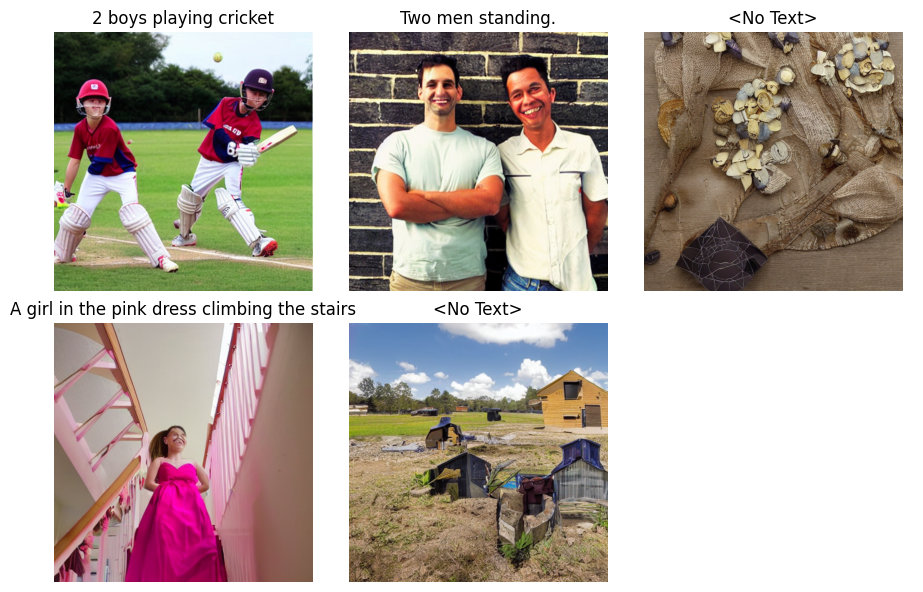

In [20]:
diffusion_model.plot_images(
    images=images,
    prompts=prompts
)

In [ ]:
prompts = [
    ""
]
images = diffusion_model.generate_image(
    prompts=prompts,
    g=7.5,
    seed=100,
    steps=70,
    dim=height,
    save_int=True
)
diffusion_model.plot_images(
    images=images,
    prompts=prompts
)